In [24]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

import plotly.express as px
import plotly.graph_obj as go

from fenginering.function import *
from fenginering.indicator import *
from fenginering.transformer import *
from fenginering.preprocessing import Crossover
from fenginering.preprocessing import Scale
from data.get_data import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
start = "2019"
end = "2023"
data = get_data('BTC', '1h').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

(37527, 5)

In [18]:
def get_classification_target(data):
    data = data.copy()
    data['returns'] = data["close"].pct_change()
    data['target'] = data['returns'].shift(-1)
    data['target'] = np.where(data['target'] > 0, 1, 0)
    return data['target']


data['target'] = get_classification_target(data)
data = data.iloc[:-1]

In [19]:
lag_ret_list = [1, 3, 5, 9, 15, 30]
ema_list = [3, 9, 15]
rsi_list = [10, 14, 20]

atr_list = [10, 20, 25, 30, 48, 72]

macd_dict = {
    'slow' : [10, 14],
    'fast' : [3, 5],
    'signal' : [2, 3]
}

sar_dict = {
    'step' : [0.2],
    'max_step' : [0.2]
}

stochastic_oscillator_dict = {
    'k_period' : [10, 15, 20],
    'd_period' : [3, 5]
}

Indicators = MakeIndicator(data)

Indicators.set_stransformer(lag_returns, lag_ret_list)
Indicators.set_stransformer(rsi, rsi_list)
Indicators.set_mtransformer(stochastic_oscillator, stochastic_oscillator_dict)
Indicators.set_stransformer(atr, atr_list)

data = Indicators.get_data()
n_drop = Indicators.na_count
        
norm_scale = Scale(data)
data = norm_scale.transform()

<AxesSubplot: >

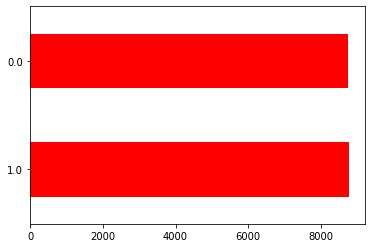

In [20]:
N = data.shape[0]
n = int(0.7*N)
train = data.loc["2021":"2022"]
test = data.loc["2023"]

features, target = train.drop(columns = ['target']), train['target']
features_test, target_test = test.drop(columns = ['target']), test['target']


target.value_counts().plot(kind = 'barh', color = 'red')

In [21]:
from model import *

proba_data = fit(models, features, target, features_test, target_test)

LogisticRegression


c:\Users\cc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Accuracy : 0.55 
 f1 : 0.52 
 precision : 0.59 
 recall : 0.47 
 AUC : 0.58 
    -      -    -
    -      -    -
RandomForestClassifier
 Accuracy : 0.53 
 f1 : 0.52 
 precision : 0.56 
 recall : 0.48 
 AUC : 0.54 
    -      -    -
    -      -    -
XGBClassifier
 Accuracy : 0.52 
 f1 : 0.52 
 precision : 0.55 
 recall : 0.50 
 AUC : 0.54 
    -      -    -
    -      -    -
GBM
 Accuracy : 0.55 
 f1 : 0.55 
 precision : 0.57 
 recall : 0.54 
 AUC : 0.56 
    -      -    -
    -      -    -
HGBM
 Accuracy : 0.55 
 f1 : 0.55 
 precision : 0.57 
 recall : 0.54 
 AUC : 0.56 
    -      -    -
    -      -    -


,LogisticRegression,RandomForestClassifier,XGBClassifier,GBM,HGBM
0,0.486788,0.41,0.540007,0.381004,0.533339
1,0.453016,0.39,0.310371,0.277102,0.484520
2,0.468575,0.47,0.210046,0.371388,0.467407
3,0.490433,0.55,0.440084,0.443726,0.505578
4,0.517244,0.37,0.525785,0.465280,0.501238
...,...,...,...,...,...
2516,0.532561,0.53,0.679199,0.534656,0.541886
2517,0.452209,0.42,0.472922,0.460262,0.510727
2518,0.503034,0.58,0.467385,0.593190,0.506953
2519,0.516688,0.50,0.497630,0.514310,0.482853


In [25]:
px.box(pd.DataFrame(proba_data))

In [27]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators = models, voting = 'soft')
model.fit(features, target)

c:\Users\cc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



VotingClassifier(estimators=[('LogisticRegression', LogisticRegression()),
                             ('RandomForestClassifier',
                              RandomForestClassifier()),
                             ('XGBClassifier',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, gr...
                                            learning_rate=0.300000012,
                                            max_bin=256, max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=0,
                                            reg_alpha=0, reg_lambda=1, ...)),
                             ('GBM', GradientBoostingClassifier()),
                             ('HGBM', HistGradientBoostingClassifier())],
                 voting='soft')

 Accuracy : 0.54 
 f1 : 0.54 
 precision : 0.56 
 recall : 0.51 
 AUC : 0.56 
              precision    recall  f1-score   support

         0.0       0.52      0.57      0.55      1210
         1.0       0.56      0.51      0.54      1311

    accuracy                           0.54      2521
   macro avg       0.54      0.54      0.54      2521
weighted avg       0.54      0.54      0.54      2521



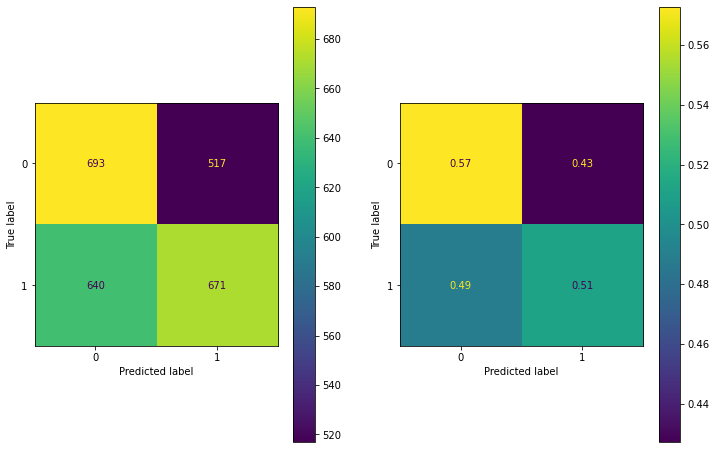

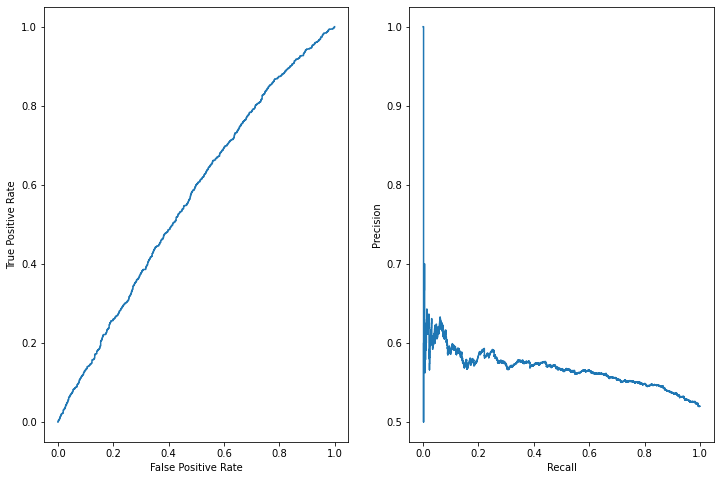

In [28]:
y_pred = model.predict(features_test)
y_pred_proba = model.predict_proba(features_test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()